<hr>

## <h3 align="center"> EEIA 2024 -- Projet Résumé automatique de textes légaux <h3/>

<p>


Réalisé par : Dhalil BELLO et Vital GUINGUINNI

## Objectif du projet
L'objectif de ce projet est de résumer des sections de textes légaux à partir d'un modèle d'IA pré-entrainé.


## Données

Dataset open source de 446 sections de texte avec résumés


## Étapes du Notebook


1.   Installation et chargement des librairies
2.   Chargement, nettoyage et pré-processing des données
4.   Entrainement et sauvegarde du modèle

## 1.  Installation et chargement des librairies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import Dataset

# 2. Chargement, nettoyage et pre-processing des données

In [3]:
# Chemins vers le jeu de données
open_source_path = '/content/drive/MyDrive/Resume/data/open_source_dataset.json'

In [4]:
# Fonction pour charger et formatter les données depuis un fichier JSON
def load_and_format_data(file_path):
    """Loads and formats data from a given JSON file into a list of dictionaries,
    where each dictionary represents an item with its unique ID and associated data."""
    with open(file_path, 'r') as file:
        data = json.load(file)
        formatted_data = [{'uid': key, **value} for key, value in data.items()]
    return formatted_data

In [5]:
# Fonction pour nettoyer les textes
def clean_text(text):
    """Cleans the given text by removing HTML tags, non-alphabetic characters,
    and extra spaces, then returns the cleaned text."""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [6]:
# Chargement et formattage du jeu de données
open_source_dataset = load_and_format_data(open_source_path)

In [7]:
# Conversion en Dataframe pour faciliter la manipulation
open_source_df = pd.DataFrame(open_source_dataset)

In [8]:
# Nettoyage des textes
open_source_df['original_text_clean'] = open_source_df['original_text'].apply(clean_text)
open_source_df['reference_summary_clean'] = open_source_df['reference_summary'].apply(clean_text)

In [9]:
# Analyse de la longeur des textes originaux et des résumés associés
original_text_lengths = open_source_df['original_text_clean'].apply(len)
summary_lengths = open_source_df['reference_summary_clean'].apply(len)

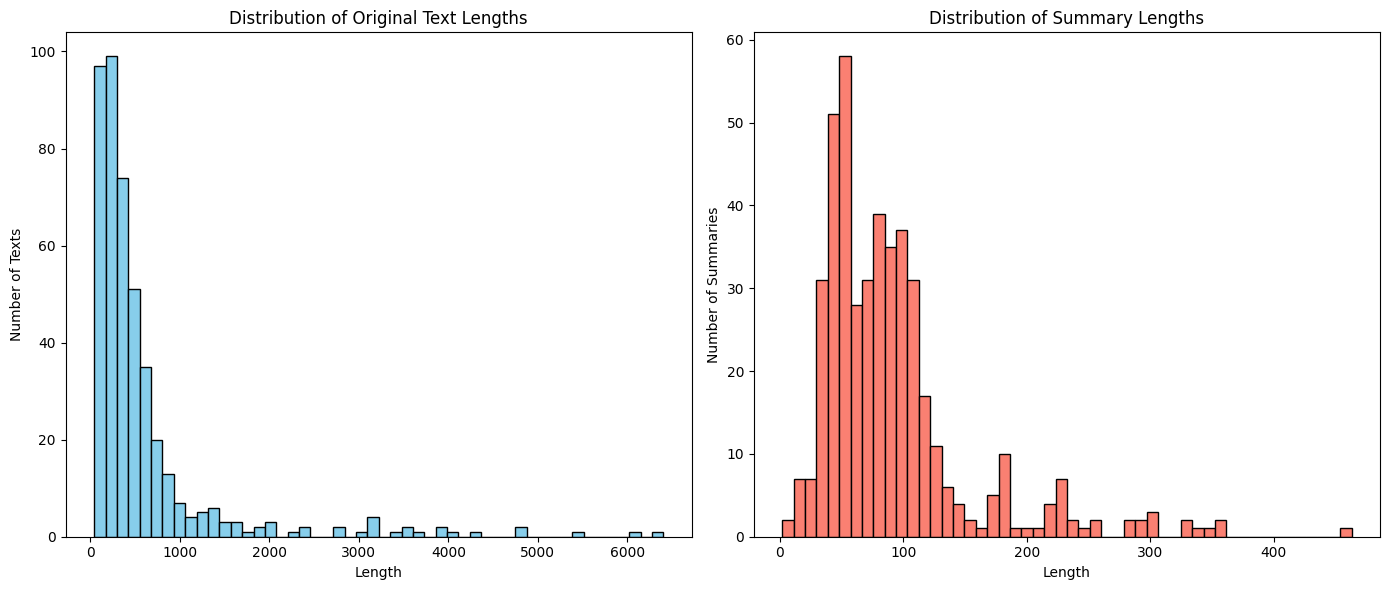

In [10]:
# Création de graphique pour la distribution des longueurs de textes
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(original_text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Text Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Texts')

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Summaries')

plt.tight_layout()
plt.show()

# 3. Entrainement et sauvegarde du modèle

In [11]:
# Initialisé le tokeniser et le modèle
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-6-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-6-6")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Data preprocessing function
def preprocess_data(df):
    """Tokenizes the texts and summaries in the dataframe using the BART tokenizer,
    then adds tokenized data as new columns for model training."""
    # Tokenize texts and summaries
    tokenized_data = tokenizer(df['original_text_clean'].tolist(), padding="max_length", truncation=True,
                               max_length=256, return_tensors="pt")
    tokenized_summaries = tokenizer(df['reference_summary_clean'].tolist(), padding="max_length", truncation=True,
                                    max_length=256, return_tensors="pt")

    # Convert tensors to lists for compatibility with pandas
    df['input_ids'] = tokenized_data['input_ids'].tolist()
    df['attention_mask'] = tokenized_data['attention_mask'].tolist()
    df['labels'] = tokenized_summaries['input_ids'].tolist()

    return df

In [13]:
open_source_df = preprocess_data(open_source_df)

In [14]:
# Diviser le jeu de données en training et test set
train_df, test_df = train_test_split(open_source_df, test_size=0.2, random_state=42)

In [15]:
# Customisation du dataset pour l'entrainement
class SummaryDataset(Dataset):
    """A custom Dataset class for handling the tokenized text data for training and evaluation."""
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_mask = df['attention_mask'].tolist()
        self.labels = df['labels'].tolist()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [16]:
# Création des objets d'entrainement du dataset
train_dataset = SummaryDataset(train_df)
eval_dataset = SummaryDataset(test_df)

In [17]:
!pip install transformers[torch]

In [18]:
from transformers import Trainer, TrainingArguments


In [19]:
# Configuration des paramètres d'entrainement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [20]:
# Initialisé et démarrer l'entrainement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()

Step,Training Loss
10,11.384700
20,10.887000
30,9.736000
40,8.801600
50,7.300500
60,5.232900
70,3.357300
80,2.150400
90,1.442800
100,1.044700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=1190, training_loss=0.5897783390301116, metrics={'train_runtime': 131.5913, 'train_samples_per_second': 27.053, 'train_steps_per_second': 9.043, 'total_flos': 964372746731520.0, 'train_loss': 0.5897783390301116, 'epoch': 10.0})

In [22]:
# Sauvegarder le modèle entrainé et le tokeniser
model.save_pretrained('/content/drive/MyDrive/Resume/model_saved')
tokenizer.save_pretrained('/content/drive/MyDrive/Resume/model_saved')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/content/drive/MyDrive/Resume/model_saved/tokenizer_config.json',
 '/content/drive/MyDrive/Resume/model_saved/special_tokens_map.json',
 '/content/drive/MyDrive/Resume/model_saved/vocab.json',
 '/content/drive/MyDrive/Resume/model_saved/merges.txt',
 '/content/drive/MyDrive/Resume/model_saved/added_tokens.json',
 '/content/drive/MyDrive/Resume/model_saved/tokenizer.json')